In [38]:
# import pandas as pd
# import mysql.connector
# import os

# # List of CSV files and their corresponding table names
# csv_files = [
#     ('customers.csv', 'customers'),
#     ('orders.csv', 'orders'),
#     ('sellers.csv', 'sellers'),
#     ('products.csv', 'products'),
#     ('geolocation.csv', 'geolocation'),
#     ('payments.csv', 'payments'),
#     ('order_items.csv','order_items')# Added payments.csv for specific handling
# ]

# # Connect to the MySQL database
# conn = mysql.connector.connect(
#     host='localhost',
#     user='root',
#     password='Nikk@9978',
#     database='ecommerce'
# )
# cursor = conn.cursor()

# # Folder containing the CSV files
# folder_path = 'D:/New folder/OneDrive/Desktop/E-commerce'

# def get_sql_type(dtype):
#     if pd.api.types.is_integer_dtype(dtype):
#         return 'INT'
#     elif pd.api.types.is_float_dtype(dtype):
#         return 'FLOAT'
#     elif pd.api.types.is_bool_dtype(dtype):
#         return 'BOOLEAN'
#     elif pd.api.types.is_datetime64_any_dtype(dtype):
#         return 'DATETIME'
#     else:
#         return 'TEXT'

# for csv_file, table_name in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
    
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(file_path)
    
#     # Replace NaN with None to handle SQL NULL
#     df = df.where(pd.notnull(df), None) 
    
#     # Debugging: Check for NaN values
#     print(f"Processing {csv_file}")
#     print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

#     # Clean column names
#     df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

#     # Generate the CREATE TABLE statement with appropriate data types
#     columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
#     create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
#     cursor.execute(create_table_query)

#     # Insert DataFrame data into the MySQL table
#     for _, row in df.iterrows():
#         # Convert row to tuple and handle NaN/None explicitly
#         values = tuple(None if pd.isna(x) else x for x in row)
#         sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
#         cursor.execute(sql, values)

#     # Commit the transaction for the current CSV file
#     conn.commit()

# # Close the connection
# conn.close()

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host='localhost',
                            username='root',
                            password='Nikk@9978',
                            database='ecommerce')
cur = db.cursor()


# List all the cities where customers are Located.

In [26]:
query="select distinct customer_city from customers"

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [27]:
query="select count(order_id) from orders where year(order_purchase_timestamp) = 2017"

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are",data

('total orders placed in 2017 are', [(225505,)])

# Find the total sales per category.

In [28]:
query=""" select upper(products.product_category) category, 
sum(payments.payment_value) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category", "sales"])
df

,category,sales
0,PERFUMERY,5.067387e+05
1,FURNITURE DECORATION,1.430176e+06
2,TELEPHONY,4.868821e+05
3,BED TABLE BATH,1.712554e+06
4,AUTOMOTIVE,8.522943e+05
...,...,...
69,CDS MUSIC DVDS,1.199430e+03
70,LA CUISINE,2.913530e+03
71,FASHION CHILDREN'S CLOTHING,7.856700e+02
72,PC GAMER,2.174430e+03


# Calculate the percentage of orders that were paid in installments.

In [29]:
query=""" select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments 
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

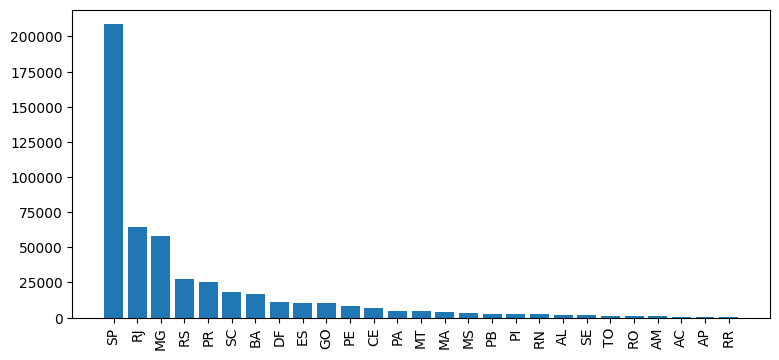

In [30]:
query=""" select customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by ="customer_count",ascending=False)

plt.figure(figsize =(9,4))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.show()

# Intermediate Queries
# 1. Calculate the number of orders per month in 2018.

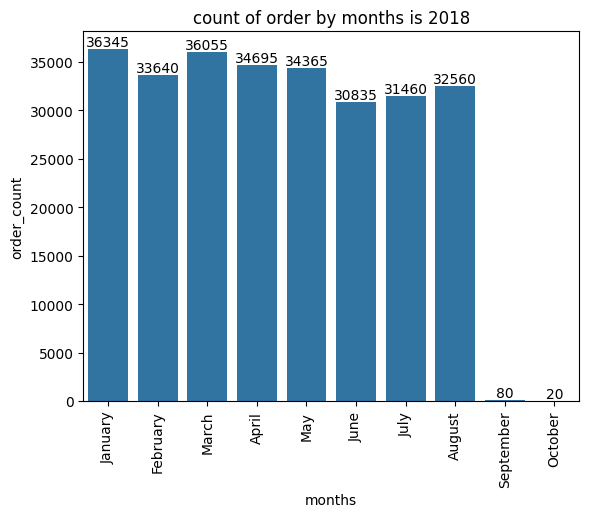

In [31]:
query=""" select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp)= 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x=df["months"],y=df["order_count"], data=df, order= o)
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.title("count of order by months is 2018")
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [32]:
query=""" WITH count_per_order AS (
  SELECT 
    orders.order_id,
    orders.customer_id,
    COUNT(order_items.order_id) AS oc
  FROM ecommerce.orders 
  JOIN ecommerce.order_items
    ON orders.order_id = order_items.order_id
  GROUP BY orders.order_id, orders.customer_id
)

SELECT 
  customers.customer_city, 
  ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM ecommerce.customers 
JOIN count_per_order
  ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city; 
"""

cur.execute(query)

data = cur.fetchall()
data

[('treze tilias', Decimal('6.36')),
 ('indaial', Decimal('5.58')),
 ('sao jose dos campos', Decimal('5.69')),
 ('sao paulo', Decimal('5.78')),
 ('porto alegre', Decimal('5.87')),
 ('santos', Decimal('5.81')),
 ('sao francisco do sul', Decimal('6.18')),
 ('sao vicente', Decimal('5.45')),
 ('joinville', Decimal('5.51')),
 ('sao vendelino', Decimal('5.00')),
 ('belo horizonte', Decimal('5.72')),
 ('bage', Decimal('5.24')),
 ('gravatai', Decimal('5.31')),
 ('sumare', Decimal('5.66')),
 ('rio de janeiro', Decimal('5.73')),
 ('navegantes', Decimal('5.81')),
 ('chapada do norte', Decimal('5.00')),
 ('frederico westphalen', Decimal('5.36')),
 ('contagem', Decimal('5.72')),
 ('curitiba', Decimal('5.80')),
 ('guaranta', Decimal('5.00')),
 ('miracema', Decimal('5.26')),
 ('campo grande', Decimal('5.71')),
 ('rodeio', Decimal('5.71')),
 ('barueri', Decimal('5.58')),
 ('urussanga', Decimal('5.00')),
 ('osorio', Decimal('5.86')),
 ('duque de caxias', Decimal('5.74')),
 ('coronel joao sa', Decimal('5

# 3. Calculate the percentage of total revenue contributed by each product category.

In [33]:
query=""" SELECT  
  UPPER(ecommerce.products.product_category) AS category,  
  ROUND(
    SUM(ecommerce.payments.payment_value) * 100.0 /
    (SELECT SUM(payments.payment_value) FROM ecommerce.payments), 
    2
  ) AS percentage_of_total_revenue
FROM ecommerce.products  
JOIN ecommerce.order_items 
  ON ecommerce.products.product_id = ecommerce.order_items.product_id
JOIN ecommerce.payments 
  ON ecommerce.payments.order_id = ecommerce.order_items.order_id
WHERE ecommerce.products.product_category IS NOT NULL 
  AND TRIM(ecommerce.products.product_category) != ''
GROUP BY UPPER(ecommerce.products.product_category)
ORDER BY percentage_of_total_revenue DESC;  
"""

cur.execute(query)

df = pd.DataFrame(data, columns = ["category", "Percentages Distribution"])
df.head(5)

,category,Percentages Distribution
0,treze tilias,6.36
1,indaial,5.58
2,sao jose dos campos,5.69
3,sao paulo,5.78
4,porto alegre,5.87


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [39]:
query = """
SELECT 
  products.product_category,
  COUNT(order_items.product_id) AS total_products_sold,
  ROUND(AVG(order_items.price), 2) AS average_price
FROM ecommerce.products
JOIN ecommerce.order_items
  ON products.product_id = order_items.product_id
GROUP BY products.product_category;
"""

# # First, consume any pending results
# try:
#     while cur.nextset():
#         pass  # clears unread results
# except:
#     pass  # safe fallback if no prior query

# # Now execute safely
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["category", "order_count", "price"])


arr1 = df["order_count"]
arr2 = df["price"]

a=np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is",a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

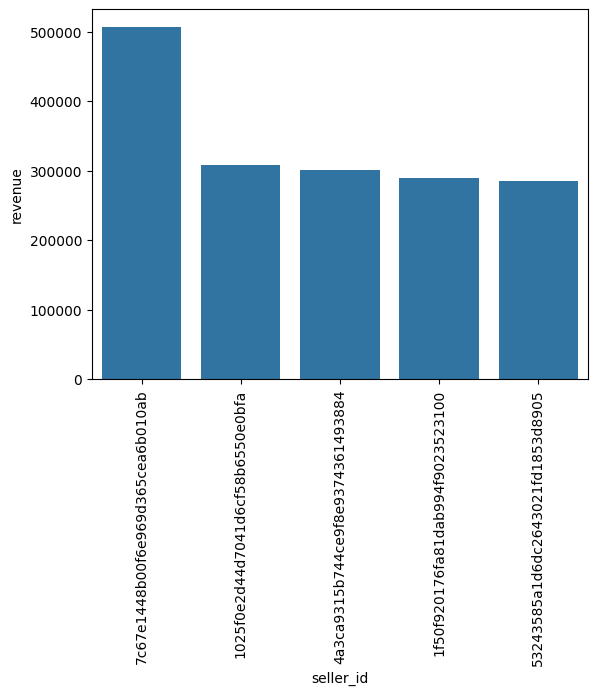

In [53]:
query="""  select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x = "seller_id", y = "revenue", data=df)
plt.xticks(rotation = 90)
plt.show()

# Advanced Queries
# 1. Calculate the moving average of order values for each customer over their order history.

In [55]:
query="""   SELECT 
  customer_id, 
  order_purchase_timestamp, 
  payment_value,  -- correct reference instead of 'payment'
  ROUND(AVG(payment_value) OVER (
    PARTITION BY customer_id 
    ORDER BY order_purchase_timestamp 
    ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
  ), 2) AS mov_avg
FROM (
  SELECT 
    ecommerce.orders.customer_id, 
    ecommerce.orders.order_purchase_timestamp, 
    ecommerce.payments.payment_value
  FROM ecommerce.payments
  JOIN ecommerce.orders  
    ON ecommerce.payments.order_id = ecommerce.orders.order_id
) AS a
ORDER BY customer_id, order_purchase_timestamp;
"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns = ["customer_id","order_purchase_timestamp","payment_value","mov_avg"])
df

,customer_id,order_purchase_timestamp,payment_value,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
...,...,...,...,...
519425,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
519426,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
519427,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
519428,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37


# 2. Calculate the cumulative sales per month for each year.

In [58]:
query="""   select years, months , payment, sum(payment)
over(order by years,months) cumulative_sales from

(SELECT year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from ecommerce.orders join ecommerce.payments
on orders.order_id = payments.order_id
group by years, months) as a;
"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns=["years","months","payment","cumulative_sum"])
df

,years,months,payment,cumulative_sum
0,2016,9,1261.20,1261.20
1,2016,10,295452.40,296713.60
2,2016,12,98.10,296811.70
3,2017,1,692440.20,989251.90
4,2017,2,1459540.05,2448791.95
5,2017,3,2249318.00,4698109.95
6,2017,4,2088940.15,6787050.10
7,2017,5,2964594.10,9751644.20
8,2017,6,2556381.90,12308026.10
9,2017,7,2961914.60,15269940.70


# 3. Calculate the year-over-year growth rate of total sales.

In [64]:
query = """
WITH a AS (
  SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value), 2) AS payment
  FROM ecommerce.orders 
  JOIN ecommerce.payments 
    ON orders.order_id = payments.order_id
  GROUP BY years
)

SELECT 
  years,
  ROUND(((payment - LAG(payment, 1) OVER (ORDER BY years)) / LAG(payment, 1) OVER (ORDER BY years)) * 100, 2) AS yoy_growth_percent
FROM a
ORDER BY years;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [65]:
query = """  WITH first_orders AS (
  SELECT 
    customer_id,
    MIN(order_purchase_timestamp) AS first_order_date
  FROM ecommerce.orders
  GROUP BY customer_id
),

repeat_orders AS (
  SELECT 
    o.customer_id,
    MIN(o.order_purchase_timestamp) AS second_order_date
  FROM ecommerce.orders o
  JOIN first_orders f 
    ON o.customer_id = f.customer_id
  WHERE o.order_purchase_timestamp > f.first_order_date
    AND o.order_purchase_timestamp <= DATE_ADD(f.first_order_date, INTERVAL 6 MONTH)
  GROUP BY o.customer_id
)

SELECT 
  ROUND(COUNT(repeat_orders.customer_id) / COUNT(first_orders.customer_id) * 100, 2) AS retention_rate_percent
FROM first_orders
LEFT JOIN repeat_orders 
  ON first_orders.customer_id = repeat_orders.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
data

[(Decimal('0.00'),)]

# 5. Identify the top 3 customers who spent the most money in each year.

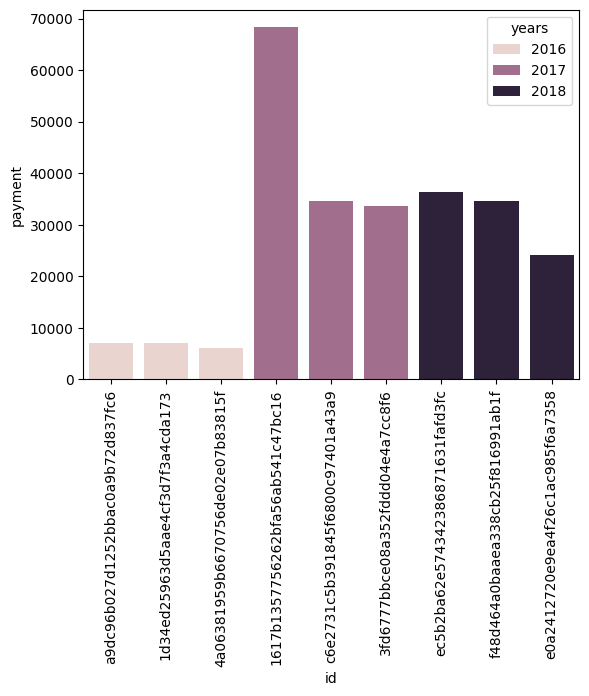

In [70]:
query = """
WITH yearly_spending AS (
  SELECT
    o.customer_id,
    YEAR(o.order_purchase_timestamp) AS order_year,
    ROUND(SUM(p.payment_value), 2) AS total_spent
  FROM ecommerce.orders o
  JOIN ecommerce.payments p 
    ON o.order_id = p.order_id
  GROUP BY o.customer_id, YEAR(o.order_purchase_timestamp)
),

ranked_spending AS (
  SELECT *,
    RANK() OVER (
      PARTITION BY order_year
      ORDER BY total_spent DESC
    ) AS spend_rank
  FROM yearly_spending
)

SELECT 
  order_year,
  customer_id,
  total_spent,
  spend_rank
FROM ranked_spending
WHERE spend_rank <= 3
ORDER BY order_year, spend_rank;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])
sns.barplot(x= "id", y= "payment", data = df, hue= "years")
plt.xticks(rotation = 90)
plt.show()